# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 2 people, the notebook should be named:
12301230_3434343_lab1.ipynb.

**IMPORTANT: This will be parsed by a regexp, so please double check your filename.**

**Only one member of each group has to submit the file to canvas.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE`.**

**Finally, please add your names and email adresses below.**



NAME = "Didier Merk"
NAME2 = "Boaz Beukers"
EMAIL = "didier.merk@gmail.com"
EMAIL2 = "boazbeuk007@gmai.com"

# Lab 1: Linear Regression and Overfitting

### Machine Learning 1, September/October 2022

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your TA.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* For this lab, your regression solutions should be in closed form, i.e., should not perform iterative gradient-based optimization but find the exact optimum directly.
*Use the provided test boxes to check if your answers are correct.
* **Do not change the arugments in our functions!**
* **Do not remove add new cells. If you do so you should expect a penalty from ourside!**

### Relevant materials for this assignment

* Erik's video lectures Week 3 and 4 
* Christopher Bishop book: Pattern recognition and machine learning (Chapter 3)
* Mathematics for machine learning (Section 8.3 and 8.4)

In [73]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [74]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True


module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '3.5.1'), 
               ('numpy', '1.22.3'), 
               ('python', '3.9.5'), 
               ('sklearn', '1.1.1'), 
               ('scipy', '1.7.3'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x = __import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

Relevant materials for this part:

* Erik's lecture 3.1 and 3.2
* Section 1.1 and 3.1 from Bishop's book Pattern recognition for machine learning.
* Mathematics for machine learning (Section 8.3)


### 1.1. Generate periodic data (5 points)
Write a method `gen_sine(N)` that generates toy data like in fig 1.2 of Bishop's book. The method should have a parameter $N$, and should return $N$-dimensional vectors $\mathbf{x}$ and $\mathbf{t}$, where $\mathbf{x}$ contains evenly spaced values from 0 to (including) 2$\pi$, and the elements $t_i$ of $\mathbf{t}$ are distributed according to:

$$t_i \sim \mathcal{N}(\mu_i, \sigma^2)$$

where $x_i$ is the $i$-th elements of $\bf{x}$, the mean $\mu_i = \sin(x_i)$ and the standard deviation $\sigma = 0.25$. You can make use of `np.random.normal()` (Hint: Double check its input parameters).


In [75]:
def gen_sine(n):
    # Generate x from [0, 2pi]
    x = np.linspace(0, 2*np.pi, num=n)
    
    # Mu is the sinus of the datapoints x
    mu = np.sin(x)
    sigma = 0.25
    
    # t is distributed according to a normal distribution
    t = np.random.normal(mu, sigma)

    return x, t

In [76]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 1.2 Polynomial regression (10 points)

Write a method `fit_polynomial(x, t, M)` that finds the maximum-likelihood solution of an _unregularized_ $M$-th order polynomial for some dataset `x`. The error function to minimize w.r.t. $\mathbf{w}$ is:

$E(\mathbf{w}) = \frac{1}{2} (\mathbf{\Phi} \mathbf{w} - \mathbf{t})^T(\mathbf{\Phi} \mathbf{w} - \mathbf{t})$

where $\mathbf{\Phi}$ is the _feature matrix_ (or _design matrix_) as explained in Bishop's book at section 3.1.1, $\mathbf{t}$ is the vector of target values. Your method should return a vector $\mathbf{w}$ with the maximum-likelihood parameter estimates, as well as the _feature matrix_ $\mathbf{\Phi}$.

In [77]:
def designmatrix(x, M): # it is highly recommended to write a helper function that computes Phi
    # Get the shape of our designmatrix
    num_rows = len(x)
    num_cols = M+1
    
    # Initialize and empty matrix for phi
    phi = np.empty([num_rows, num_cols])
    
    # Create the design matrix phi with two for loops
    for i in range(num_rows):
        for j in range(num_cols):
            phi[i][j] = x[i]**j
            
    return phi
    
def fit_polynomial(x, t, M):
    # Make the designmatrix
    Phi = designmatrix(x, M)
    
    # Calculate the weights accordingly (derivative of E(w) w.r.t. w = 0)
    w_ml = ((t.T@ Phi) @ np.linalg.inv((Phi.T @ Phi)))
    
    return w_ml, Phi


In [78]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
w, Phi = fit_polynomial(x,t,m)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of Phi is incorrect"



### 1.3 Plot (5 points)
Sample a dataset with $N=10$, and fit four polynomials with $M \in (0, 2, 4, 8)$.
For each value of $M$, plot the prediction function, along with the data and the original sine function. The resulting figure should look similar to fig 1.4 of the Bishop's book. Note that you can use matplotlib's `plt.pyplot(.)` functionality for creating grids of figures.

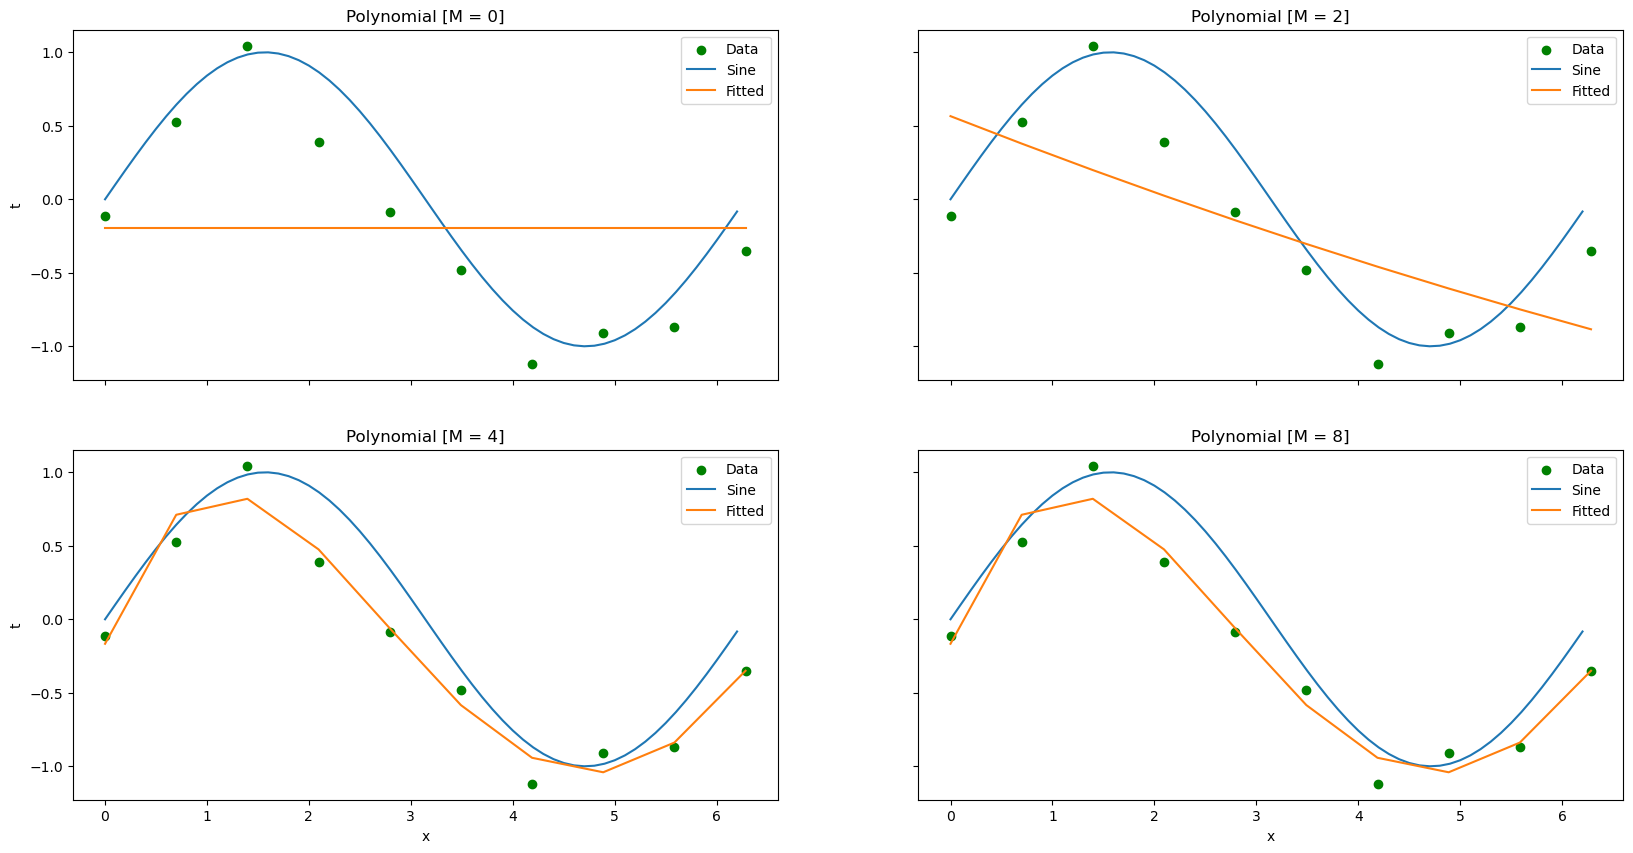

In [79]:
# Generate the data
x, t = gen_sine(10)

# Get the weights and designmatrices
w_0, phi_0 = fit_polynomial(x, t, 0)
w_2, phi_2 = fit_polynomial(x, t, 2)
w_4, phi_4 = fit_polynomial(x, t, 4)
w_8, phi_8 = fit_polynomial(x, t, 8)

# Data to plot the original sine function
sin_x = np.arange(0,2*np.pi,0.1)   # start,stop,step
sin_y = np.sin(sin_x)

# Plotting information
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(x, t, color='green', label='Data')
axs[0, 0].plot(sin_x, sin_y, label='Sine')
axs[0, 0].plot(x, phi_0 @ w_0, label='Fitted')
axs[0, 0].set_title('Polynomial [M = 0]')

axs[0, 1].scatter(x, t, color='green', label='Data')
axs[0, 1].plot(sin_x, sin_y, label='Sine')
axs[0, 1].plot(x, phi_2 @ w_2, label='Fitted')
axs[0, 1].set_title('Polynomial [M = 2]')

axs[1, 0].scatter(x, t, color='green', label='Data')
axs[1, 0].plot(sin_x, sin_y, label='Sine')
axs[1, 0].plot(x, phi_4 @ w_4, label='Fitted')
axs[1, 0].set_title('Polynomial [M = 4]')

axs[1, 1].scatter(x, t, color='green', label='Data')
axs[1, 1].plot(sin_x, sin_y, label='Sine')
axs[1, 1].plot(x, phi_4 @ w_4, label='Fitted')
axs[1, 1].set_title('Polynomial [M = 8]')

# Set x and y axis labels and legend
for ax in axs.flat:
    ax.set(xlabel='x', ylabel='t')
    ax.legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()

### 1.4 Regularized linear regression (15 points)

Relevant material for this part:

* Lecture 3.5 (Regularized Least Squares)
* Section 1.1 and 3.1.4 from Bishop's book Pattern recognition for machine learning.
* Mathematics for machine learning (Section 8.3.2)

a) (10 points) Write a method `fit_polynomial_reg(x, t, M, lamb)` that fits a _regularized_ $M$-th order polynomial to the periodic data, as discussed in the lectures, where `lamb` is the regularization term _lambda_. (Note that 'lambda' cannot be used as a variable name in Python since it has a special meaning). The error function to minimize w.r.t. $\mathbf{w}$:

$E(\mathbf{w}) = \frac{1}{2} (\mathbf{\Phi}\mathbf{w}- \mathbf{t})^T(\mathbf{\Phi}\mathbf{w}- \mathbf{t}) + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}$


The function should return $\mathbf{w}$ and $ \mathbf{\Phi} $.

In [83]:
def fit_polynomial_reg(x, t, m, lamb):
    # Create the designmatrix
    Phi = designmatrix(x, m)
    
    # Initialize and identity matrix
    ID = np.identity(m+1)
    
    # Calculate the weights according to formula in Bishop (page 145, formula 3.28)
    w_ml = linalg.inv(lamb*ID + (Phi.T @ Phi)) @ (Phi.T @ t)
    
    return w_ml, Phi

# Below we have written a function that displays the difference between the normal
# polynomial regression and the regularized linear regression. Use the function
# 'reg_vs_nonreg()' to display graphs that showcase the difference. This can be
# done by uncommenting the last line in this code block (useful for question 1.4b)

def reg_vs_nonreg():
    # Set your variables
    N = 10
    x = np.linspace(-1, 1, N)
    t = 0.3*np.square(x) + 2.5
    m = 2
    lamb = 0.1

    # Calculate the regularized and normal weights and designmatrix
    w, Phi = fit_polynomial(x,t,m)
    w_reg, Phi_reg = fit_polynomial_reg(x,t,m,lamb)

    # Plotting information
    fig, axs = plt.subplots(1, 2)

    # Plot non regularized function
    axs[0].scatter(x, t, color='green', label='Data')
    axs[0].plot(x, Phi @ w, label='Fitted')
    axs[0].set_title('Normal polynomial regression')

    # Plot regularized function
    axs[1].scatter(x, t, color='green', label='Data')
    axs[1].plot(x, Phi_reg @ w_reg, label='Fitted')
    axs[1].set_title('Regularized')

    # Set x and y axis labels and legend
    for ax in axs.flat:
        ax.set(xlabel='x', ylabel='t')
        ax.legend()

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    plt.show()
    
    return

# Uncomment next line to show difference:
# reg_vs_nonreg()

In [84]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
m = 2
lamb = 0.1
w, Phi = fit_polynomial_reg(x,t,m, lamb)

assert w.shape == (m+1,), "The shape of w is incorrect"
assert Phi.shape == (N, m+1), "The shape of w is incorrect" 



b) (5 points) What changes do you notice in $\mathbf{w}$ and $\mathbf{\Phi}$ after introducing the regularization term? Why is this happening? 

(Write no more than 5 lines. For example, you can consider the simple test case with $t = 0.3*x^2 + 2.5$)

<span style="color:red">Answer: </span> The first thing to notice is that Phi (the designmatrix) does not change because it is not dependent on lambda. The lambda that is introduced is the regularization term and it does have an effect on the weights. When this term is 0, what we are doing is basically maximum likelihood optimization. When lambda is set to a higher value, extreme values are surpressed by setting a penalty, which prevents overfitting. What happens in this simple $t = 0.3*x^2 + 2.5$ case can be demonstrated in the function previously written called 'reg_vs_nonreg()'. It shows that the curve does not go directly through the datapoints anymore but takes a more general form.

### 1.5 Model selection by cross-validation (15 points)

Relevant material for this part:

* Lecture 4.1 and 4.2 (Model Selection, Bias Variance Decomposition)

Use cross-validation to find a good choice of $M$ and $\lambda$, given a dataset of $N=10$ datapoints generated with `gen_sine(10)`. You should write a function that tries (loops over) a reasonable range of choices of $M$ and $\lambda$, and returns the choice with the best cross-validation error. In this case you use $K=5$ folds.

You can let $M \in (0, 1, ..., 10)$, and let $\lambda \in (e^{-10}, e^{-9}, ..., e^{0})$.

a) (5 points) First of all, write a method `pred_error(x_train, x_valid, t_train, t_valid, M, lamb)` that compares the prediction of your method `fit_polynomial_reg` for a given set of parameters $M$ and $\lambda$ to `t_valid`. It should return the prediction error for a single fold.

In [85]:
def pred_error(x_train, x_valid, t_train, t_valid, M, reg):
    # Get your weights and phi using previously made function
    weights, Phi = fit_polynomial_reg(x_train, t_train, M, reg)
    
    # Get the validation Phi using the designmatrix function and x_valid
    Phi_valid = designmatrix(x_valid, M)
    
    # Retrieve predictions using the designmatrix and the weights
    pred = Phi_valid @ weights
    
    # The prediction error is calculated as follows
    pred_err = t_valid - pred
    pred_err = (pred_err.T @ pred_err) / 2
    
    return pred_err


In [86]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
reg = 0.1
pred_err = pred_error(x[:-2], x[-2:], t[:-2], t[-2:], M, reg)

assert pred_err < 0.001, "pred_err is too big"



b) (10 points) Now write a method find_best_m_and_lamb(x, t) that finds the best values for $M$ and $\lambda$. The method should return the best $M$ and $\lambda$. To get you started, here is a method you can use to generate indices of cross-validation folds.

In [87]:
def kfold_indices(N, k):
    all_indices = np.arange(N,dtype=int)
    np.random.shuffle(all_indices)
    idx = [int(i) for i in np.floor(np.linspace(0,N,k+1))]
    train_folds = []
    valid_folds = []
    for fold in range(k):
        valid_indices = all_indices[idx[fold]:idx[fold+1]]
        valid_folds.append(valid_indices)
        train_folds.append(np.setdiff1d(all_indices, valid_indices))
    return train_folds, valid_folds


In [88]:
def find_best_m_and_lamb(x, t):
    # Set your variables
    K = 5
    
    # M ranges from 0 to 10
    M = np.linspace(0, 10, 11).astype(int)

    # Labda ranges from e^-10 to e^-0
    labda = []
    
    for i in range(11):
        labda += [np.e**(-10+i)]
    
    # Retrieve your train and valid folds
    train_folds, valid_folds = kfold_indices(N, K)
    
    # Initialize a list to store your prediction errors per 5 folds
    avg_pred_err = []
    
    # For every value of M
    for m in M:
        # And for every value of labda
        for lab in labda:
            pred_err = []
            
            # Perform the K-fold cross validation
            for fold in range(K):
                x_train = [x[data] for data in train_folds[fold]]
                x_valid = [x[data] for data in valid_folds[fold]]
                t_train = [t[data] for data in train_folds[fold]]
                t_valid = [t[data] for data in valid_folds[fold]]
                
                # Calculate the predition error
                pred_err += [pred_error(x_train, x_valid, t_train, t_valid, m, lab)]
                
            # Store the prediction error per fold together with the corresponding m and labda values
            avg_pred_err += [[np.mean(pred_err), m, lab]]
    
    # Now retrieve the lowest prediction error and its corresponding lambda and M
    
    # Full list of prediction errors
    list_of_pred_errs = [error[0] for error in avg_pred_err]
    
    # Get the index of the lowest error
    index_lowest_error = list_of_pred_errs.index(min(list_of_pred_errs))
    
    # The M_best and lamb_best are the values corresponding with the lowest prediction error
    # Use the index we just found to retrieve them
    M_best, lamb_best = avg_pred_err[index_lowest_error][1], avg_pred_err[index_lowest_error][2]
    
    return M_best, lamb_best

# Test the function
N = 10
x, t = gen_sine(N)

find_best_m_and_lamb(x, t)

(5, 0.1353352832366127)

In [89]:
### This is not an empty cell (You don't need to care about it).

### 1.6 Why grid search? (5 points)

Grid search is an commonly-used technique to tune hyper-parameters in a model.
Considering the case described in the previous step of this assignment, running a grid search over the possible parameter values (10 possible values for both $M$ and $\lambda$), results in two nested loops exploring $10 \times 10 = 100$ different configurations for the model. 

a) (3 points) Why do we want to optimize by changing the two hyperparameters at the same time, and not in a sequential way? We could initialise all parameters randomly, fix one parameter at a time and iterate over the other, resulting in only $10 + 10 = 20$ experiments!

<span style="color:red">Answer: </span> This would not be a method that is guaranteed to find the optimal parameters, because parameters depend on each other. When we look at our previous example, our parameters labda and M are not independent. 

This means that when, for example, M gets fixed on 2 and we iterate over the different lambdas to find the optimal value: it does not mean that this value for lambda is also the optimal value when we change our M. It is necessary to check every possible combination of lambdas and M, because the behaviour of one parameter changes when another parameter changes. Using grid search, we ensure that by checking every combination we find the global optimal values of the parameters.

For more complex models, the number of combinations easily explodes with the number of parameters. For example, with 5 parameters we would run $10 \times 10 \times 10 \times 10 \times 10 = 100,000$ experiments.

b) (2 points) Try to think or find in literature one alternative to grid search to tune hyper-parameters more efficiently. Explain very briefly (2-3 lines max) how this method avoids the combinatorial explosion we have see in grid search.

<span style="color:red">Answer: </span> As seen in the previous exercise, grid-search 'brute-forces' its way to hyperparameter optimization by trying every possible combination of hyperparameters. However, there are other algorithms such as random search that combat the issue that arises when there is a larger number of parameters. Random search selects random combinations of hyperparameters in order to find the best one. It is a lot more efficient than grid search, but on the other hand is not guarenteed to find the globally best combination of parameters.

### 1.7 Plot best cross-validated fit (5 points)

For some dataset with $N = 10$, plot the model with the optimal $M$ and $\lambda$ according to the cross-validation error, using the method you just wrote. In addition, the plot should show the dataset itself and the function that we try to approximate. Let the plot make clear which $M$ and $\lambda$ were found.

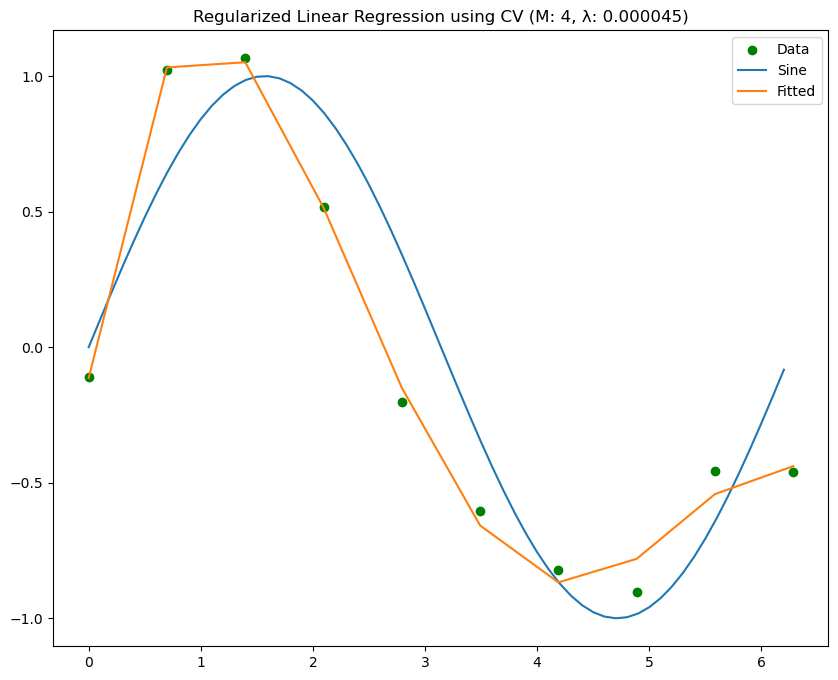

In [90]:
# Retrieve the data
N = 10
x, t = gen_sine(N)
opt_M, opt_lamb = find_best_m_and_lamb(x, t)

# Get the weights and designmatrix
w_ml, phi = fit_polynomial_reg(x, t, opt_M, opt_lamb)

# Data to plot the original sine function
sin_x = np.arange(0,2*np.pi,0.1)
sin_y = np.sin(sin_x)

# Plot a figure
fig = plt.figure(figsize =(10, 8)) 

# Three different plots
plt.scatter(x, t, color='green', label='Data')
plt.plot(sin_x, sin_y, label='Sine')
plt.plot(x, phi @ w_ml, label='Fitted')

# optimal M and lambda in the title and a legend
plt.title("Regularized Linear Regression using CV (M: %i" %opt_M + ", λ: %.6f)" %opt_lamb)
plt.legend()

plt.show()

## Part 2: Bayesian Linear (Polynomial) Regression

Relevant material for this part:

* Lecture 4.4 and 4.5 (Sequential Bayesian Learning, Bayesian Predictive Distributions)
* Section 1.1 and 3.3 from Bishop's book Pattern recognition for machine learning.
* Mathematics for machine learning (Section 8.4)

### 2.1 Sine 2 (5 points)

Write a function `gen_sine2(N)` that behaves identically to `gen_sine(N)` except that the generated values $x_i$ are not linearly spaced, but drawn from a uniform distribution between $0$ and $2 \pi$.

In [91]:
def gen_sine2(n):    
    # Draw x from a uniform distribution between [0, 2pi]
    x = np.random.uniform(0, 2*np.pi, n)
    
    # Mu is the sinus of the datapoints x
    mu = np.sin(x)
    sigma = 0.25
    
    # t is distributed according to a normal distribution
    t = np.random.normal(mu, sigma)

    return x, t

In [92]:
### Test your function
np.random.seed(42)
N = 10
x, t = gen_sine2(N)

assert x.shape == (N,), "the shape of x is incorrect"
assert t.shape == (N,), "the shape of t is incorrect"



### 2.2 Compute Posterior (15 points)

You're going to implement a Bayesian linear regression model, and fit it to the periodic data. Your regression model has a zero-mean isotropic Gaussian prior over the parameters, governed by a single (scalar) precision parameter $\alpha$, i.e.:

$$p(\mathbf{w} \;|\; \alpha) = \mathcal{N}(\mathbf{w} \;|\; 0, \alpha^{-1} \mathbf{I})$$

The covariance and mean of the posterior are given by:

$$\mathbf{S}_N= \left( \alpha \mathbf{I} + \beta \mathbf{\Phi}^T \mathbf{\Phi} \right)^{-1} $$
$$\mathbf{m}_N = \beta\; \mathbf{S}_N \mathbf{\Phi}^T \mathbf{t}$$

where $\alpha$ is the precision of the predictive distribution, and $\beta$ is the noise precision. 
See MLPR chapter 3.3 for background.

Write a method `fit_polynomial_bayes(x, t, M, alpha, beta)` that returns the mean $\mathbf{m}_N$ and covariance $\mathbf{S}_N$ of the posterior for a $M$-th order polynomial. In addition it should return the design matrix $\mathbf{\Phi}$. The arguments `x`, `t` and `M` have the same meaning as in question 1.2.

In [93]:
def fit_polynomial_bayes(x, t, M, alpha, beta):
    ID_matrix = np.identity(M+1)
    Phi = designmatrix(x, M)
    
    S = np.linalg.inv((alpha * ID_matrix) + (beta * (Phi.T @ Phi)))
    m = beta * ((S @ Phi.T) @ t)
    
    return m, S, Phi


In [94]:
### Test your function
N = 10
x = np.linspace(-1, 1, N)
t = 0.3*np.square(x) + 2.5
M = 2
alpha = 0.6
beta = 16
m, S, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)

assert m.shape == (M+1,), "the shape of m is incorrect" 
assert S.shape == (M+1, M+1), "the shape of S is incorrect"
assert Phi.shape == (N, M+1), "the shape of Phi is incorrect"



### 2.3 Prediction (10 points)

The predictive distribution of Bayesian linear regression is:

$$ p(t \;|\; \mathbf{x}, \mathbf{t}, \alpha, \beta) = \mathcal{N}(t \;|\; \mathbf{m}_N^T \phi(\mathbf{x}), \sigma_N^2(\mathbf{x}))$$

$$ \sigma_N^2 = \frac{1}{\beta} + \phi(\mathbf{x})^T \mathbf{S}_N \phi(\mathbf{x}) $$

where $\phi(\mathbf{x})$ are the computed features for a new datapoint $\mathbf{x}$, and $t$ is the predicted variable for datapoint $\mathbf{x}$. 

Write a function that `predict_polynomial_bayes(x, m, S, beta)` that returns the predictive mean, variance and design matrix $\mathbf{\Phi}$ given a new datapoint `x`, posterior mean `m`, posterior variance `S` and a choice of model variance `beta`.

In [95]:
def predict_polynomial_bayes(x, m, S, beta):
    # Create a designmatrix of correct order polynomial
    order = len(m) - 1
    Phi = designmatrix(x, order)
    
    # Calculate the mean using the designmatrix
    mean = m @ Phi.T

    # Calculate the sigma elementwise
    sigma = np.empty(x.shape)
    
    for i in range(len(x)):
        # Use the function given above for the variance
        sigma[i] = (1 / beta) + (Phi[i].T @ S @ Phi[i])

    return mean, sigma, Phi


In [96]:
### Test your function
np.random.seed(42)
N = 10
x = np.linspace(-1, 1, N)
m = np.random.rand(3)
S = np.random.rand(3, 3)
beta = 16
mean, sigma, Phi = predict_polynomial_bayes(x, m, S, beta)

assert mean.shape == (N,), "the shape of mean is incorrect"
assert sigma.shape == (N,), "the shape of sigma is incorrect"
assert Phi.shape == (N, m.shape[0]), "the shape of Phi is incorrect"



### 2.4 Plot predictive distribution (10 points)

a) (5 points) Generate 10 datapoints with `gen_sine2(10)`. Compute the posterior mean and covariance for a Bayesian polynomial regression model with $M=4$, $\alpha=\frac{2}{5}$ and $\beta=\frac{1}{0.25^2}$.
Plot the Bayesian predictive distribution, where you plot (for $x$ between 0 and $2 \pi$) $t$'s predictive mean and the predictive standard deviation using `plt.fill_between(..., alpha=0.1)` (the alpha argument induces transparency).

Include the datapoints in your plot.


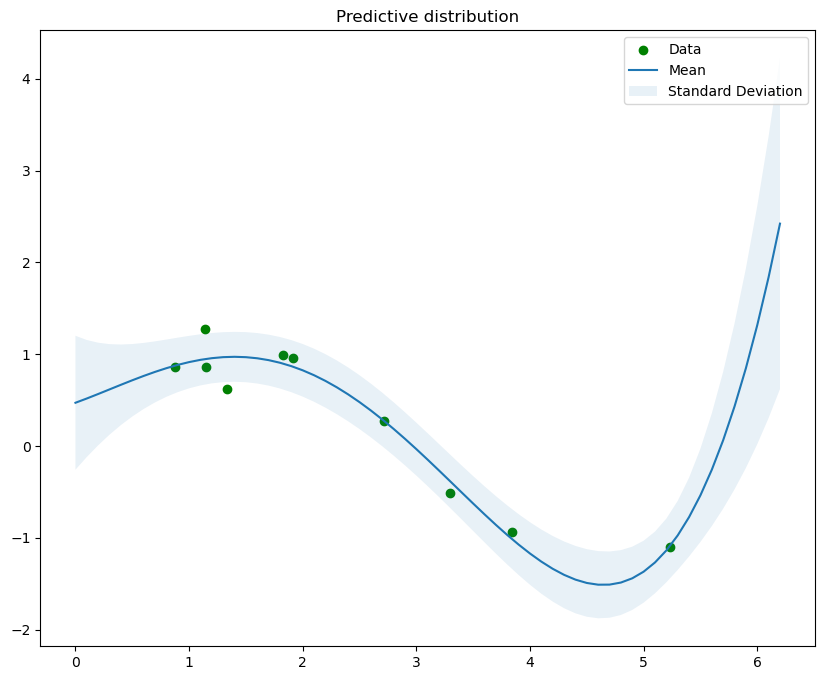

In [97]:
# Generate 10 datapoints
N = 10
x, t = gen_sine2(N)

# Set your variables
M = 4
alpha = 2/5
beta = 1/(0.25**2)

# Sinusoide data points 
sin_x = np.arange(0, 2*np.pi, 0.1)

# Also use the above variables for question 2.4b

# Compute the posterior mean and covariance
mean, cov, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)

# Predict the polynomial
pred_mean, pred_var, Phi = predict_polynomial_bayes(sin_x, mean, cov, beta)

# Plot the standard deviation instead of the variance (square root)
pred_std = np.sqrt(pred_var)

# Plot the figure
fig = plt.figure(figsize =(10, 8)) 

# Three different plots
plt.scatter(x, t, color='green', label='Data')
plt.plot(sin_x, pred_mean, label='Mean')
plt.fill_between(sin_x, pred_mean - pred_std, pred_mean + pred_std, alpha=0.1, label='Standard Deviation')

# Add title and legend to plot
plt.title("Predictive distribution")
plt.legend()

plt.show()

b) (5 points) For a second plot, draw 100 samples from the parameters' posterior distribution. Each of these samples is a certain choice of parameters for 4-th order polynomial regression. 
Display each of these 100 polynomials.


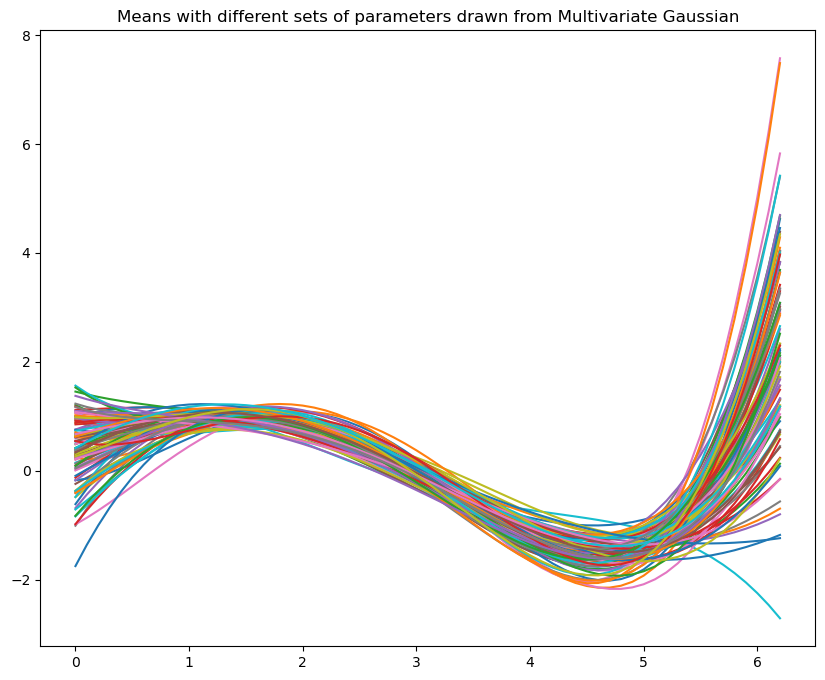

In [98]:
# Retrieve your mean and cov
mean, cov, Phi = fit_polynomial_bayes(x, t, M, alpha, beta)

# Draw from multivariate Gaussians with found mean, cov
samples = np.random.multivariate_normal(mean, cov, 100)

# Initialize the figure
fig = plt.figure(figsize =(10, 8))

# For all set of parameters plot the predictive distribution
for i in samples:
    # Calculate the predictive mean and predictive sigma
    pred_mean, pred_sigma, pred_Phi = predict_polynomial_bayes(sin_x, i, cov, beta)
    
    # Draw the plot
    plt.plot(sin_x, pred_mean, label='Mean')

plt.title("Means with different sets of parameters drawn from Multivariate Gaussian")
plt.show()


### 2.5 Additional questions (10 points)

a) (5 points) Why is $\beta=16$ the best choice of $\beta$ in section 2.4?



<span style="color:red">Answer: </span> $\beta$ is defined as $(1 / \sigma)^2$. When we assume here that the noise variance is known, the best choice of $\beta$ is to set it to its true value. In the question this was $(1 / 0.25)^2 = 16$. See also page 154, section 3.3.1 in Bishop!

b) (5 points) What problems do we face when it comes to choosing basis functions in linear models?

<span style="color:red">Answer: </span> When choosing which basic functions to use, there is not a standard recipe to follow. The basis functions you chose are in correspondence with your data; for example in this exercise we use polynomial basis functions, but there might be more complicated datasets where these do not work. By choosing these basic functions on your dataset there is a chance that these chosen basis functions lead to overfitting. However, if we chose different or less basis functions there is a chance we underfit.